This part tries to get height information from the SWOT_L2_HR_PIXC_2.0 dataset

In [2]:
# Standard library imports
from datetime import datetime
import json
from pathlib import Path
import os
import glob
import zipfile

# Third-party library imports
import geopandas as gpd
import pandas as pd
import contextily as ctx
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import earthaccess

# Matplotlib inline magic command
%matplotlib inline

g:\Programme\AnacondaNavigator\envs\SWOT_2024_ANC\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('config.json', 'r') as f:
    config = json.load(f)

print(config)

{'data_dir': 'data', 'sampling_points_shapefile': 'res\\Reservoirs.shp', 'water_mask_pixel_cloud_dir': 'data\\Water mask pixel cloud', 'temporal_range': ['2024-02-01T00:00:00', '2024-02-29T00:00:00'], 'product_short_name': 'SWOT_L2_HR_PIXC_2.0', 'bounding_box': [36.8584632059703, -0.8194088619079362, 37.2444933070158, -0.03771035197995866]}


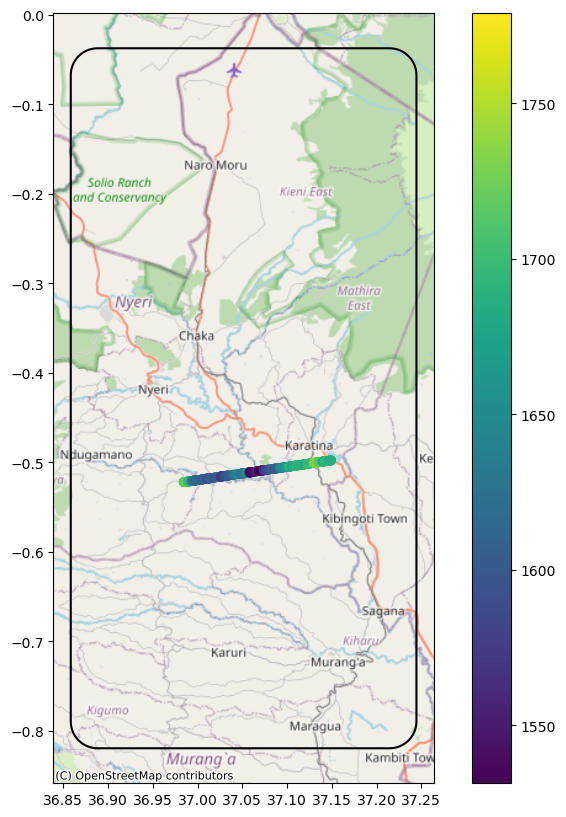

In [4]:
# 1. Identify and open the first NetCDF file in the pixel cloud directory
pixel_cloud_dir = Path(config['water_mask_pixel_cloud_dir'])
file_list = list(pixel_cloud_dir.glob('*.nc'))
filepath = file_list[0]  # Take the first file found

# 2. Load the pixel_cloud dataset and select the last 10,000 entries
ds = xr.open_dataset(filepath, group='pixel_cloud').tail(1000)

# 3. Load the bounding box from a GeoJSON file as a GeoDataFrame
bbox_path = Path(config['data_dir']) / 'bbox.geojson'
with open(bbox_path, 'r') as f:
    bbox_data = json.load(f)
bbox_gdf = gpd.GeoDataFrame.from_features(bbox_data['features'])

# 4. Clip the dataset to the bounding box
ds_clipped = ds.where(
    (ds.latitude >= bbox_gdf.bounds.miny[0]) &
    (ds.latitude <= bbox_gdf.bounds.maxy[0]) &
    (ds.longitude >= bbox_gdf.bounds.minx[0]) &
    (ds.longitude <= bbox_gdf.bounds.maxx[0]),
    drop=True
)

# 5. Convert clipped data into a GeoDataFrame (EPSG:4326)
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(ds_clipped.longitude.values, ds_clipped.latitude.values),
    crs='EPSG:4326'
)

# 6. Populate the GeoDataFrame with relevant data columns
data_columns = ['height']
for col in data_columns:
    gdf[col] = ds_clipped[col].values

# 7. (Optional) Convert 'height' to meters above sea level if needed
#    The data originates from the SWOT mission and uses a custom reference ellipsoid.
#    For example, if you have an offset or scale factor, you would apply it here.

# 8. Plot the resulting GeoDataFrame, colored by 'height'
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='height', ax=ax, legend=True, cmap='viridis')
bbox_gdf.boundary.plot(ax=ax, color='black')

# Add a basemap (requires contextily)
ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()
